# 3. Modeling

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 3.1 Prepare data

In [209]:
file_path = '../data/processed/preprocessed_data.csv' 

data = np.genfromtxt(
    file_path,
    delimiter=',',
    skip_header=1,    # Skip header row
    dtype=float         # Load as strings (no preprocessing)
)

data[:5]

array([[ 0.92 ,  3.584,  1.   ,  1.   ,  0.   ,  3.   ,  1.   , 21.   ,
         3.   ,  5.   ,  1.   ,  1.584,  1.   ],
       [ 0.776,  3.85 ,  1.   ,  0.   ,  0.   ,  3.   ,  1.   , 15.   ,
         2.   ,  5.   ,  5.   , -0.983,  0.   ],
       [ 0.624,  4.419,  0.   ,  0.   ,  2.   ,  3.   ,  1.   ,  5.   ,
         1.   ,  3.   ,  0.   ,  0.594,  0.   ],
       [ 0.789,  3.951,  0.   ,  0.   ,  0.   ,  3.   ,  0.   ,  0.   ,
         0.   ,  5.   ,  0.   , -0.992,  1.   ],
       [ 0.767,  2.079,  1.   ,  1.   ,  0.   ,  4.   ,  1.   , 21.   ,
         2.   ,  4.   ,  4.   , -0.947,  0.   ]])

In [210]:
with open(file_path, "r", encoding='utf-8') as file:
    columns = file.readline().split(",")
columns = [item.strip() for item in columns if item.strip()]
columns

['city_dev_index',
 'training_hour',
 'gender',
 'relevent_exp',
 'enrolled_uni',
 'education_level',
 'major',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'city',
 'target']

In [211]:
col_idx = {c: i for i, c in enumerate(columns)}
col_arrays = {c: data[:, i] for c, i in col_idx.items()}

print(col_idx)

{'city_dev_index': 0, 'training_hour': 1, 'gender': 2, 'relevent_exp': 3, 'enrolled_uni': 4, 'education_level': 5, 'major': 6, 'experience': 7, 'company_size': 8, 'company_type': 9, 'last_new_job': 10, 'city': 11, 'target': 12}


In [212]:
# Overview: shape, missing values, and type summary
n_rows, n_cols = data.shape
print(f"Rows: {n_rows}, Columns: {n_cols}")

def _is_float(s):
    try:
        float(s)
        return True
    except Exception:
        return False

safe_float_vec = np.vectorize(lambda x: float(x) if _is_float(str(x).strip()) else np.nan)

# Missing mask helper
_missing_tokens = np.array(['', 'na', 'nan', 'null', 'none', '?'], dtype='<U5')


def missing_mask(arr):
    s = np.char.lower(np.char.strip(arr.astype(str)))
    return (s == '') | np.isin(s, _missing_tokens)

# Missing per column
missing_stats = []
for col in columns:
    arr = col_arrays[col]
    m = missing_mask(arr)
    missing_stats.append((col, int(m.sum()), float(m.mean())))

missing_stats_sorted = sorted(missing_stats, key=lambda x: x[1], reverse=True)
print("\nTop missing columns:")
for col, cnt, rate in missing_stats_sorted:
    print(f"- {col}: {cnt} ({rate:.4%})")

Rows: 19158, Columns: 13

Top missing columns:
- city_dev_index: 0 (0.0000%)
- training_hour: 0 (0.0000%)
- gender: 0 (0.0000%)
- relevent_exp: 0 (0.0000%)
- enrolled_uni: 0 (0.0000%)
- education_level: 0 (0.0000%)
- major: 0 (0.0000%)
- experience: 0 (0.0000%)
- company_size: 0 (0.0000%)
- company_type: 0 (0.0000%)
- last_new_job: 0 (0.0000%)
- city: 0 (0.0000%)
- target: 0 (0.0000%)


In [213]:
X_train = data[:, :n_cols - 1]
X_train

array([[ 0.92 ,  3.584,  1.   , ...,  5.   ,  1.   ,  1.584],
       [ 0.776,  3.85 ,  1.   , ...,  5.   ,  5.   , -0.983],
       [ 0.624,  4.419,  0.   , ...,  3.   ,  0.   ,  0.594],
       ...,
       [ 0.92 ,  3.784,  1.   , ...,  5.   ,  4.   ,  1.584],
       [ 0.802,  4.575,  1.   , ...,  5.   ,  2.   , -0.919],
       [ 0.855,  4.844,  0.   , ...,  5.   ,  1.   , -0.766]])

In [214]:
y_train = data[:, -1]
y_train

array([1., 0., 0., ..., 0., 0., 0.])

## 3.2 Logistic Regression Implementation

### 3.2.1 Normal Logistic Regression with fixed learning rate and early stop

In [215]:
class LogisticRegression:
    def __init__(
        self, 
        threshold=0.5, 
        learning_rate=0.01, 
        max_iterations=50000,
        patience=30,
        print_every=100
    ):
        self.lr = learning_rate
        self.max_iter = max_iterations
        self.thres = threshold
        self.patience = patience
        self.print_every = print_every
        
        self.weights = None
        self.bias = 0
        
        self.loss_history = []
        self.acc_history = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def cost(self, logits, y):
        eps = 1e-12
        logits = np.clip(logits, eps, 1-eps)
        return -np.mean(y*np.log(logits) + (1-y)*np.log(1-logits))
    
    def accuracy(self, y_pred, y_true):
        return np.mean((y_pred > self.thres) == y_true)
    
    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.random.randn(n) * 0.01
        
        best_loss = float("inf")
        patience_counter = 0
        
        for epoch in range(1, self.max_iter + 1):
            z = X @ self.weights + self.bias
            logits = self.sigmoid(z)
            
            loss = self.cost(logits, y)
            preds = (logits > self.thres).astype(int)
            acc = self.accuracy(preds, y)

            # Store logs
            self.loss_history.append(loss)
            self.acc_history.append(acc)
            
            # Gradient
            dw = (X.T @ (logits - y)) / m
            db = np.sum(logits - y) / m
            
            # Update
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
            # Early stopping
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopped at epoch {epoch} (no improvement for {self.patience} steps)")
                break
            
            # Print training stats
            if epoch % self.print_every == 0 or epoch == 1:
                print(f"Epoch {epoch}: Loss = {loss:.4f}, Acc = {acc:.4f}")
    
    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)
    
    def predict(self, X):
        return (self.predict_proba(X) > self.thres).astype(int)


### 3.2.2 Logistic Regression with Adam Optimizer and class weighting

In [216]:
import numpy as np

class LogisticRegressionAdam:
    def __init__(
        self,
        threshold=0.5,
        learning_rate=0.001,
        max_iterations=50000,
        patience=50,
        print_every=100,
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
        weight_class = False
    ):
        self.lr = learning_rate
        self.max_iter = max_iterations
        self.thres = threshold
        self.patience = patience
        self.print_every = print_every

        # Adam parameters
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        self.weights = None
        self.bias = None

        self.loss_history = []
        self.acc_history = []

        # Adam moment variables
        self.m_w = None
        self.v_w = None
        self.m_b = 0
        self.v_b = 0

        self.weight_class = weight_class

        self.class_weights = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost(self, logits, y):
        eps = 1e-12
        logits = np.clip(logits, eps, 1 - eps)
        if self.weight_class:
            w = np.where(y == 1, self.class_weights[1], self.class_weights[0])
        else:
            w = np.ones_like(y)
        return -np.mean(w * (y * np.log(logits) + (1 - y) * np.log(1 - logits)))

    def accuracy(self, preds, y):
        return np.mean(preds == y)

    def fit(self, X, y):

        if (self.weight_class):
            N = len(y)
            N1 = np.sum(y)
            N0 = N - N1

            w1 = N / (2 * N1 + 1e-8)
            w0 = N / (2 * N0 + 1e-8)

            self.class_weights = np.array([w0, w1])

        m, n = X.shape

        # Small random initialization
        self.weights = np.random.randn(n) * 0.01
        self.bias = 0.0

        # Adam moment init
        self.m_w = np.zeros_like(self.weights)
        self.v_w = np.zeros_like(self.weights)

        best_loss = float("inf")
        patience_counter = 0

        for epoch in range(1, self.max_iter + 1):

            # Forward
            z = X @ self.weights + self.bias
            logits = self.sigmoid(z)

            # Loss & accuracy
            loss = self.cost(logits, y)
            preds = (logits > self.thres).astype(int)
            acc = self.accuracy(preds, y)

            self.loss_history.append(loss)
            self.acc_history.append(acc)

            # Gradients

            if (self.weight_class):
                w = np.where(y == 1, self.class_weights[1], self.class_weights[0])
            else:
                w = np.ones_like(y)

            dz = (logits - y) * w
            dw = (X.T @ dz) / m
            db = np.sum(dz) / m

            # Moment estimates
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dw
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dw ** 2)

            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * db
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (db ** 2)

            # Bias correction
            m_w_hat = self.m_w / (1 - self.beta1 ** epoch)
            v_w_hat = self.v_w / (1 - self.beta2 ** epoch)

            m_b_hat = self.m_b / (1 - self.beta1 ** epoch)
            v_b_hat = self.v_b / (1 - self.beta2 ** epoch)

            # Parameter update
            self.weights -= self.lr * m_w_hat / (np.sqrt(v_w_hat) + self.eps)
            self.bias    -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.eps)


            # Early stopping
            if loss < best_loss:
                best_loss = loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopping at epoch {epoch}")
                break

            # Logging
            if epoch % self.print_every == 0 or epoch == 1:
                print(f"Epoch {epoch}: Loss={loss:.4f}, Acc={acc:.4f}")

    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights + self.bias)

    def predict(self, X):
        return (self.predict_proba(X) > self.thres).astype(int)


## 3.3 Test and Evaluate

### 3.3.1 Prepare data for testing

In [217]:
test_path = '../data/raw/aug_test.csv' 

X_test_data = np.genfromtxt(
    test_path,
    delimiter=',',
    skip_header=1,    # Skip header row
    dtype=str         # Load as strings (no preprocessing)
)

X_test_data[:5]

array([['32403', 'city_41', '0.8270000000000001', 'Male',
        'Has relevent experience', 'Full time course', 'Graduate',
        'STEM', '9', '<10', '', '1', '21'],
       ['9858', 'city_103', '0.92', 'Female', 'Has relevent experience',
        'no_enrollment', 'Graduate', 'STEM', '5', '', 'Pvt Ltd', '1',
        '98'],
       ['31806', 'city_21', '0.624', 'Male', 'No relevent experience',
        'no_enrollment', 'High School', '', '<1', '', 'Pvt Ltd', 'never',
        '15'],
       ['27385', 'city_13', '0.8270000000000001', 'Male',
        'Has relevent experience', 'no_enrollment', 'Masters', 'STEM',
        '11', '10/49', 'Pvt Ltd', '1', '39'],
       ['27724', 'city_103', '0.92', 'Male', 'Has relevent experience',
        'no_enrollment', 'Graduate', 'STEM', '>20', '10000+', 'Pvt Ltd',
        '>4', '72']], dtype='<U23')

In [218]:
with open(test_path, "r", encoding='utf-8') as file:
    test_columns = file.readline().split(",")
test_columns = [item.strip() for item in test_columns if item.strip()]
test_columns

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours']

In [219]:
len(X_test_data)

2129

In [220]:
y_test = np.load("../data/raw/jobchange_test_target_values.npy")
y_test

array([1., 0., 1., ..., 0., 0., 0.])

In [221]:
len(y_test)

2129

In [222]:
arr = np.char.lower(X_test_data)

# Create mask: keep rows without empty or "nan"
mask = ~((arr == "") | (arr == "nan")).any(axis=1)

# Apply mask
X_test_clean = X_test_data[mask]
y_test_clean = y_test[mask]

In [223]:
X_test_clean

array([['27385', 'city_13', '0.8270000000000001', ..., 'Pvt Ltd', '1',
        '39'],
       ['27724', 'city_103', '0.92', ..., 'Pvt Ltd', '>4', '72'],
       ['9272', 'city_90', '0.698', ..., 'Pvt Ltd', '2', '51'],
       ...,
       ['21500', 'city_44', '0.725', ..., 'Early Stage Startup', 'never',
        '160'],
       ['27163', 'city_173', '0.878', ..., 'Pvt Ltd', '>4', '58'],
       ['12215', 'city_102', '0.804', ..., 'Pvt Ltd', '2', '11']],
      dtype='<U23')

In [224]:
len(X_test_clean)

1019

In [225]:
len(y_test_clean)

1019

In [226]:
y_test_clean = y_test_clean.astype(float)
y_test_clean

array([0., 1., 1., ..., 0., 0., 0.])

In [227]:
col_idx = {c: i for i, c in enumerate(test_columns)}
col_arrays = {c: X_test_clean[:, i] for c, i in col_idx.items()}

In [228]:
col_arrays

{'enrollee_id': array(['27385', '27724', '9272', ..., '21500', '27163', '12215'],
       dtype='<U23'),
 'city': array(['city_13', 'city_103', 'city_90', ..., 'city_44', 'city_173',
        'city_102'], dtype='<U23'),
 'city_development_index': array(['0.8270000000000001', '0.92', '0.698', ..., '0.725', '0.878',
        '0.804'], dtype='<U23'),
 'gender': array(['Male', 'Male', 'Male', ..., 'Male', 'Male', 'Male'], dtype='<U23'),
 'relevent_experience': array(['Has relevent experience', 'Has relevent experience',
        'Has relevent experience', ..., 'No relevent experience',
        'No relevent experience', 'Has relevent experience'], dtype='<U23'),
 'enrolled_university': array(['no_enrollment', 'no_enrollment', 'no_enrollment', ...,
        'Part time course', 'no_enrollment', 'no_enrollment'], dtype='<U23'),
 'education_level': array(['Masters', 'Graduate', 'Graduate', ..., 'Graduate', 'Masters',
        'Masters'], dtype='<U23'),
 'major_discipline': array(['STEM', 'STEM', 'STE

In [229]:
city_dev_idx_col = safe_float_vec(col_arrays["city_development_index"])
print("Number of NaN value:", np.isnan(city_dev_idx_col).sum())

city_dev_idx_col

Number of NaN value: 0


array([0.827, 0.92 , 0.698, ..., 0.725, 0.878, 0.804])

In [230]:
training_hour_col = safe_float_vec(col_arrays["training_hours"])
training_hour_log = np.log(training_hour_col + 1e-8)
training_hour_log


array([3.66356165, 4.27666612, 3.93182563, ..., 5.07517382, 4.06044301,
       2.39789527])

In [231]:
gender_col = col_arrays["gender"].astype(str)
# np.isnan(gender_col).sum()
# np.unique(gender_col)
gender_col = np.where(gender_col == "Male", 1,
           np.where(gender_col == "Female", -1, 0))
np.unique(gender_col), gender_col

(array([-1,  0,  1]), array([1, 1, 1, ..., 1, 1, 1]))

In [232]:
re_exp_col = col_arrays["relevent_experience"].astype(str)
re_exp_col = np.where(re_exp_col == "Has relevent experience", 1, 0)
re_exp_col[:5]

array([1, 1, 1, 1, 1])

In [233]:
col_arrays["enrolled_university"][-1:-5:-1]

array(['no_enrollment', 'no_enrollment', 'Part time course',
       'no_enrollment'], dtype='<U23')

In [234]:
en_uni_col = col_arrays["enrolled_university"].astype(str)
en_uni_col = np.where(en_uni_col == "Full time course", 2, 
                      np.where(en_uni_col == "Part time course", 1, 0))
en_uni_col[-1:-5:-1]

array([0, 0, 1, 0])

In [235]:
edu_level_col = col_arrays["education_level"].astype(str)

# handle missing
edu_level_col = np.where(edu_level_col == "", "Unknown", edu_level_col)

edu_level_col = np.where(edu_level_col == "Primary School", 1,
           np.where(edu_level_col == "High School", 2,
           np.where(edu_level_col == "Graduate", 3,
           np.where(edu_level_col == "Masters", 4,
           np.where(edu_level_col == "Phd", 5, 0)))))
edu_level_col[:5]

array([4, 3, 3, 3, 4])

In [236]:
major_col = col_arrays["major_discipline"].astype(str)
major_col = np.where(major_col == "STEM", 1, 0)
major_col[:5]

array([1, 1, 1, 1, 1])

In [237]:
exp_col = col_arrays["experience"].astype(str)
exp_col = np.where(exp_col == "", "0", exp_col)
exp_col = np.where(exp_col == "<1", "0", exp_col)
exp_col = np.where(exp_col == ">20", "21", exp_col)

exp_col = exp_col.astype(int)

exp_col[:5]

array([11, 21, 20,  8,  4])

In [238]:
company_sz = col_arrays["company_size"]
company_sz[:5]

array(['10/49', '10000+', '10/49', '100-500', '100-500'], dtype='<U23')

In [239]:
mapping = {
    "<10": 0,
    "10/49": 1,
    "50-99": 2,
    "100-500": 3,
    "500-999": 4,
    "1000-4999": 5,
    "5000-9999": 6,
    "10000+": 7,
    "": -1,           # missing
}

# vectorized mapping
size_encoded = np.vectorize(mapping.get)(company_sz)
size_encoded_viz = size_encoded.copy()
size_encoded[:5]

array([1, 7, 1, 3, 3])

In [240]:
company_sz_col = size_encoded.copy()

In [241]:
company_type = col_arrays["company_type"]
mapping2 = {
    "Other": 0,
    "NGO": 1,
    "Early Stage Startup": 2,
    "Public Sector": 3,
    "Funded Startup": 4,
    "Pvt Ltd": 5,
    "Missing": -1,           # missing
}

company_type_ids = np.vectorize(mapping2.get)(company_type)
company_type_ids[:10]

array([5, 5, 5, 0, 5, 5, 5, 5, 5, 5])

In [242]:
(company_type_ids == -1).sum()

0

In [243]:
company_type_col = company_type_ids.copy()

In [244]:
v = col_arrays["last_new_job"].astype(str)

# Normalize missing
v = np.where(v == "", "never", v)

encoded_last_new_job = np.where(v == "never", 0,
                         np.where(v == ">4", 5, v))
encoded_last_new_job = encoded_last_new_job.astype(int)
encoded_last_new_job[:5]

array([1, 5, 2, 0, 1])

In [245]:
import json

with open("../data/processed/freq_encode.json", "r") as f:
    freq_map = json.load(f)

print(type(freq_map))   
print(freq_map["city_1"]) 


<class 'dict'>
26


In [246]:
city_col = col_arrays["city"]
freq_encoder = np.vectorize(lambda x: freq_map[x])
city_encoded = freq_encoder(city_col)
city_encoded[:5]

array([  48, 4355,  197,  128, 2702])

In [247]:
with open("../data/processed/mean_std.txt") as f:
    mean_and_std = f.read().strip().split(",")
mean, std = np.array(float(mean_and_std[0])), np.array(float(mean_and_std[1]))
mean, std

(array(1709.79642969), array(1669.89163104))

In [248]:
def transform_standard_scaler(X, mean, std):
    return (X - mean) / std

In [249]:
city_encoded_scaled = transform_standard_scaler(city_encoded, mean, std)
city_encoded_scaled[:5]

array([-0.99515226,  1.58405703, -0.90592491, -0.94724496,  0.59417243])

In [250]:
final_test_data = np.column_stack([city_dev_idx_col, training_hour_log, 
                        gender_col, re_exp_col,
                        en_uni_col, edu_level_col, 
                        major_col, exp_col,
                        company_sz_col,company_type_col, 
                        encoded_last_new_job, city_encoded_scaled]).astype(float)
final_test_data

array([[ 0.827     ,  3.66356165,  1.        , ...,  5.        ,
         1.        , -0.99515226],
       [ 0.92      ,  4.27666612,  1.        , ...,  5.        ,
         5.        ,  1.58405703],
       [ 0.698     ,  3.93182563,  1.        , ...,  5.        ,
         2.        , -0.90592491],
       ...,
       [ 0.725     ,  5.07517382,  1.        , ...,  2.        ,
         0.        , -1.0131175 ],
       [ 0.878     ,  4.06044301,  1.        , ...,  5.        ,
         5.        , -0.93347161],
       [ 0.804     ,  2.39789527,  1.        , ...,  5.        ,
         2.        , -0.8418489 ]])

### 3.3.2 It's training and testing time!

In [251]:

def confusion_matrix_np(y_true, y_pred, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))

    label_to_index = {label: idx for idx, label in enumerate(labels)}
    cm = np.zeros((len(labels), len(labels)), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[label_to_index[t], label_to_index[p]] += 1

    return cm, labels

In [252]:
def classification_report_np(y_true, y_pred):
    cm, labels = confusion_matrix_np(y_true, y_pred)

    report = {}
    for i, label in enumerate(labels):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        report[label] = {
            "precision": np.round(precision, 3),
            "recall": np.round(recall, 3),
            "f1-score": np.round(f1, 3),
            "support": cm[i, :].sum()
        }

    accuracy = np.trace(cm) / np.sum(cm)

    return report, np.round(accuracy,2), cm, labels


In [253]:
def plot_cm(cm, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels)

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [254]:
def eval_model(model):
    y_pred = model.predict(final_test_data)
    report, accuracy, cm, labels = classification_report_np(y_test_clean, y_pred)

    print("Accuracy:", accuracy)

    print("\nClassification Report:")
    for label, metrics in report.items():
        print(f"{label}: {metrics}")
    plot_cm(cm, labels)
    

In [255]:
def plot_acc_loss(model):
    plt.figure(figsize=(9, 5))
    plt.plot(model.loss_history, label="Loss")
    plt.plot(model.acc_history, label="Accuracy")
    plt.title("Loss & Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

#### 3.3.2.1 Model 1: Without Adam

In [256]:
%%time

model1 = LogisticRegression(print_every=1000)
model1.fit(X_train, y_train)

Epoch 1: Loss = 0.6692, Acc = 0.7444


Epoch 1000: Loss = 0.5316, Acc = 0.7520
Epoch 2000: Loss = 0.5270, Acc = 0.7524
Epoch 3000: Loss = 0.5237, Acc = 0.7536
Epoch 4000: Loss = 0.5210, Acc = 0.7542
Epoch 5000: Loss = 0.5186, Acc = 0.7549
Epoch 6000: Loss = 0.5166, Acc = 0.7555
Epoch 7000: Loss = 0.5148, Acc = 0.7560
Epoch 8000: Loss = 0.5132, Acc = 0.7563
Epoch 9000: Loss = 0.5118, Acc = 0.7563
Epoch 10000: Loss = 0.5105, Acc = 0.7571
Epoch 11000: Loss = 0.5093, Acc = 0.7577
Epoch 12000: Loss = 0.5083, Acc = 0.7578
Epoch 13000: Loss = 0.5073, Acc = 0.7583
Epoch 14000: Loss = 0.5063, Acc = 0.7584
Epoch 15000: Loss = 0.5055, Acc = 0.7587
Epoch 16000: Loss = 0.5047, Acc = 0.7591
Epoch 17000: Loss = 0.5039, Acc = 0.7592
Epoch 18000: Loss = 0.5032, Acc = 0.7597
Epoch 19000: Loss = 0.5026, Acc = 0.7597
Epoch 20000: Loss = 0.5020, Acc = 0.7600
Epoch 21000: Loss = 0.5014, Acc = 0.7603
Epoch 22000: Loss = 0.5008, Acc = 0.7600
Epoch 23000: Loss = 0.5003, Acc = 0.7598
Epoch 24000: Loss = 0.4998, Acc = 0.7604
Epoch 25000: Loss = 0.499

Accuracy: 0.82

Classification Report:
0.0: {'precision': 0.83, 'recall': 0.981, 'f1-score': 0.899, 'support': 824}
1.0: {'precision': 0.644, 'recall': 0.149, 'f1-score': 0.242, 'support': 195}


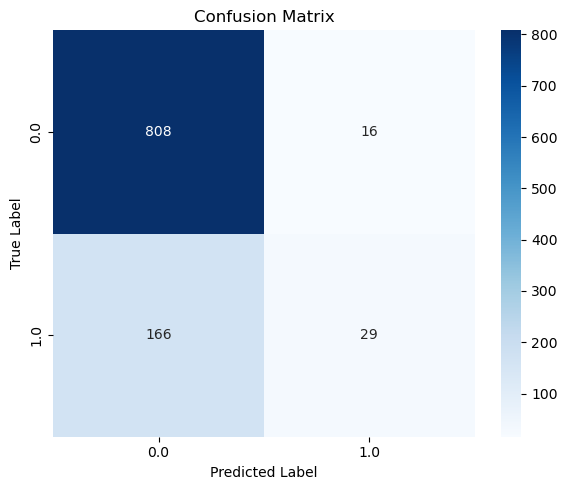

In [257]:
eval_model(model1)

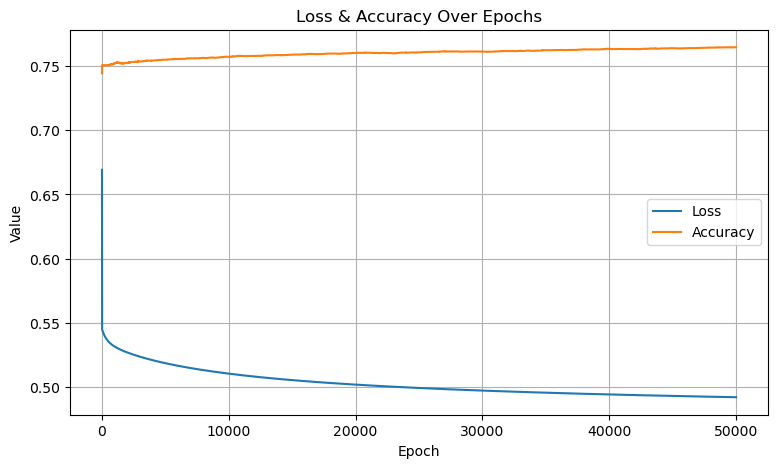

In [258]:
plot_acc_loss(model1)

#### 3.3.2.2 Model 2: With Adam

In [ ]:
%%time

model2 = LogisticRegressionAdam(print_every=1000)
model2.fit(X_train, y_train)

Epoch 1: Loss=0.6729, Acc=0.7387
Epoch 1000: Loss=0.5236, Acc=0.7532
Epoch 2000: Loss=0.5135, Acc=0.7561
Epoch 3000: Loss=0.5058, Acc=0.7584
Epoch 4000: Loss=0.4995, Acc=0.7603
Epoch 5000: Loss=0.4942, Acc=0.7631
Epoch 6000: Loss=0.4900, Acc=0.7652
Epoch 7000: Loss=0.4872, Acc=0.7686
Epoch 8000: Loss=0.4856, Acc=0.7703
Epoch 9000: Loss=0.4849, Acc=0.7727
Epoch 10000: Loss=0.4847, Acc=0.7741
Epoch 11000: Loss=0.4847, Acc=0.7754
Epoch 12000: Loss=0.4847, Acc=0.7759
Early stopping at epoch 12621
CPU times: user 37.8 s, sys: 2min 5s, total: 2min 42s
Wall time: 23.4 s


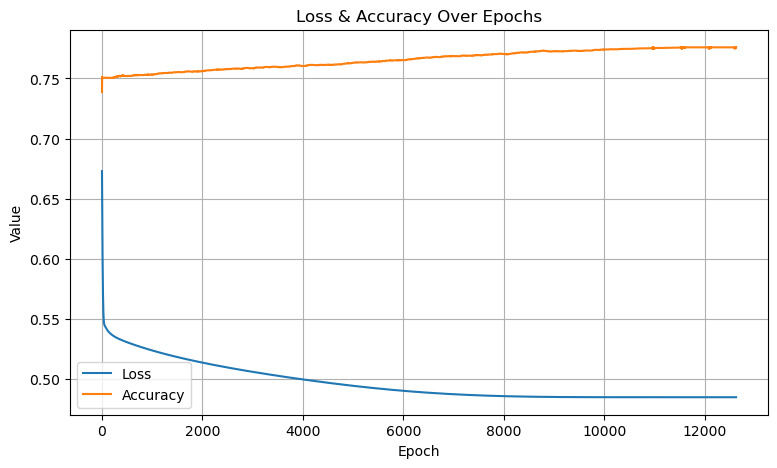

In [260]:
plot_acc_loss(model2)

Accuracy: 0.84

Classification Report:
0.0: {'precision': 0.862, 'recall': 0.949, 'f1-score': 0.904, 'support': 824}
1.0: {'precision': 0.625, 'recall': 0.359, 'f1-score': 0.456, 'support': 195}


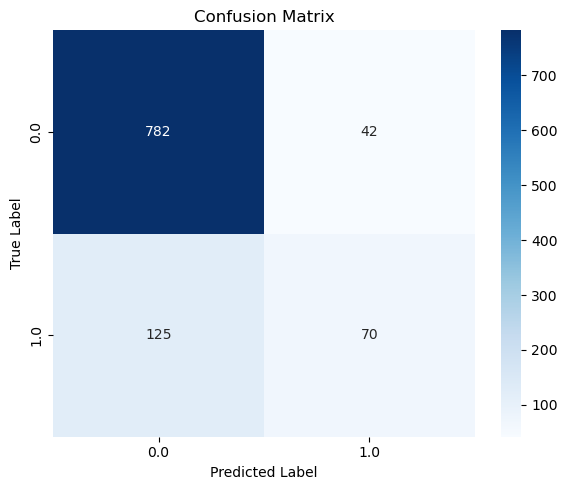

In [261]:
eval_model(model2)

#### 3.3.2.3 Model 3: With Adam and Weighted class

In [262]:
%%time

model3 = LogisticRegressionAdam(print_every=1000, weight_class=True)
model3.fit(X_train, y_train)

Epoch 1: Loss=0.7148, Acc=0.2495
Epoch 1000: Loss=0.6357, Acc=0.6598
Epoch 2000: Loss=0.6232, Acc=0.6827
Epoch 3000: Loss=0.6132, Acc=0.6993
Epoch 4000: Loss=0.6056, Acc=0.7132
Epoch 5000: Loss=0.6004, Acc=0.7234
Epoch 6000: Loss=0.5971, Acc=0.7308
Epoch 7000: Loss=0.5953, Acc=0.7333
Epoch 8000: Loss=0.5946, Acc=0.7343
Epoch 9000: Loss=0.5944, Acc=0.7337
Epoch 10000: Loss=0.5944, Acc=0.7341
Epoch 11000: Loss=0.5944, Acc=0.7341
Early stopping at epoch 11366
CPU times: user 44.6 s, sys: 2min 31s, total: 3min 16s
Wall time: 28.1 s


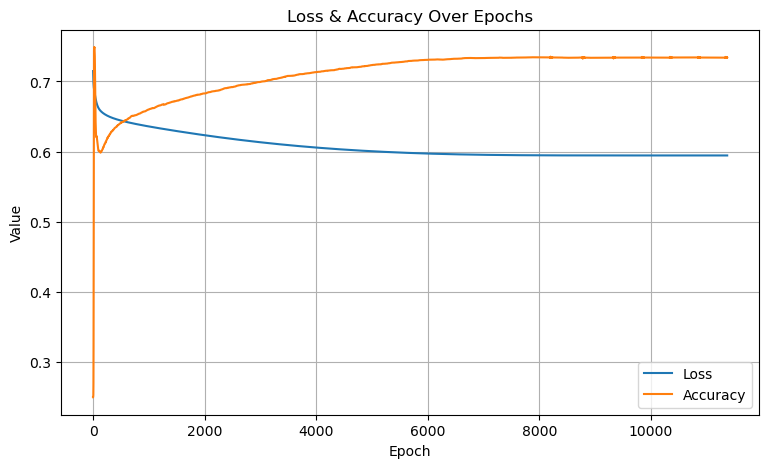

In [263]:
plot_acc_loss(model3)

Accuracy: 0.78

Classification Report:
0.0: {'precision': 0.899, 'recall': 0.825, 'f1-score': 0.861, 'support': 824}
1.0: {'precision': 0.452, 'recall': 0.61, 'f1-score': 0.52, 'support': 195}


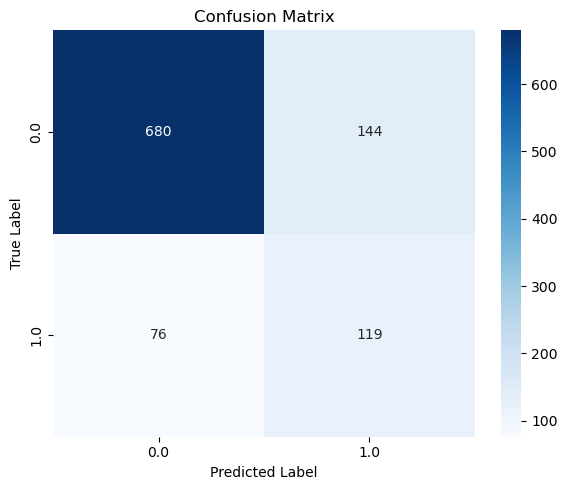

In [264]:
eval_model(model3)


#### 3.3.2.4 Model 4, 5: with Adam and tuning threshold

In [265]:
%%time

model4 = LogisticRegressionAdam(threshold=0.4, print_every=1000)
model4.fit(X_train, y_train)

Epoch 1: Loss=0.6941, Acc=0.2493
Epoch 1000: Loss=0.5244, Acc=0.7540
Epoch 2000: Loss=0.5143, Acc=0.7599
Epoch 3000: Loss=0.5065, Acc=0.7643
Epoch 4000: Loss=0.5002, Acc=0.7682
Epoch 5000: Loss=0.4948, Acc=0.7713
Epoch 6000: Loss=0.4905, Acc=0.7756
Epoch 7000: Loss=0.4875, Acc=0.7793
Epoch 8000: Loss=0.4857, Acc=0.7805
Epoch 9000: Loss=0.4849, Acc=0.7812
Epoch 10000: Loss=0.4847, Acc=0.7818
Epoch 11000: Loss=0.4847, Acc=0.7817
Epoch 12000: Loss=0.4847, Acc=0.7817
Early stopping at epoch 12373
CPU times: user 39.2 s, sys: 2min 23s, total: 3min 2s
Wall time: 27.2 s


Accuracy: 0.85

Classification Report:
0.0: {'precision': 0.894, 'recall': 0.921, 'f1-score': 0.907, 'support': 824}
1.0: {'precision': 0.618, 'recall': 0.538, 'f1-score': 0.575, 'support': 195}


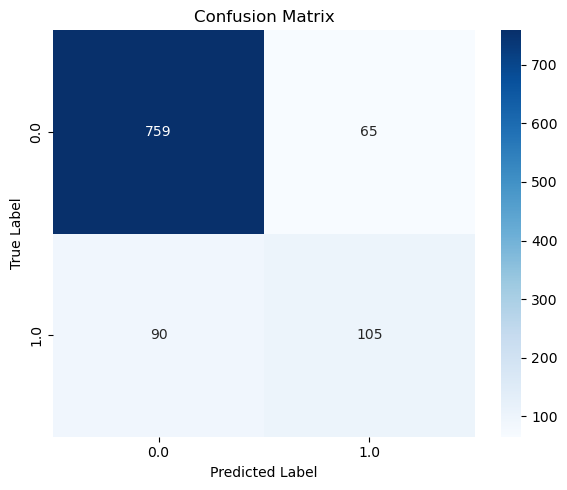

In [266]:
eval_model(model4)

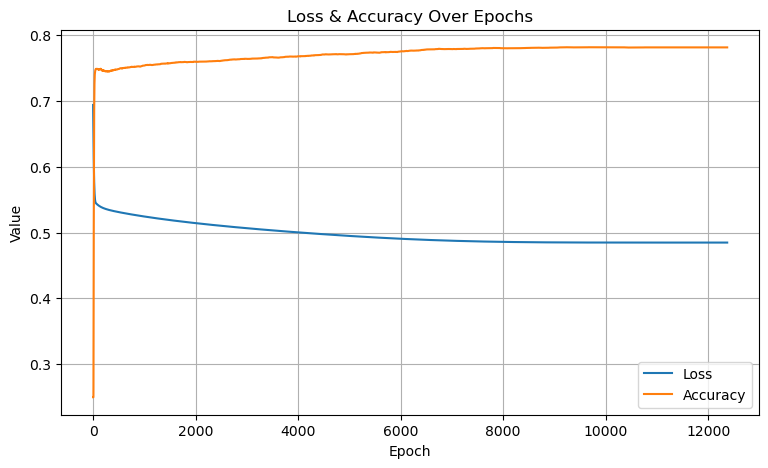

In [267]:
plot_acc_loss(model4)

In [268]:
%%time
model5 = LogisticRegressionAdam(threshold=0.3, print_every=1000)
model5.fit(X_train, y_train)

Epoch 1: Loss=0.6766, Acc=0.2493
Epoch 1000: Loss=0.5237, Acc=0.6968
Epoch 2000: Loss=0.5135, Acc=0.7211
Epoch 3000: Loss=0.5059, Acc=0.7363
Epoch 4000: Loss=0.4995, Acc=0.7491
Epoch 5000: Loss=0.4942, Acc=0.7572
Epoch 6000: Loss=0.4901, Acc=0.7602
Epoch 7000: Loss=0.4872, Acc=0.7636
Epoch 8000: Loss=0.4856, Acc=0.7651
Epoch 9000: Loss=0.4849, Acc=0.7652
Epoch 10000: Loss=0.4847, Acc=0.7649
Epoch 11000: Loss=0.4847, Acc=0.7642
Epoch 12000: Loss=0.4847, Acc=0.7647
Early stopping at epoch 12130
CPU times: user 40 s, sys: 2min 22s, total: 3min 2s
Wall time: 26.6 s


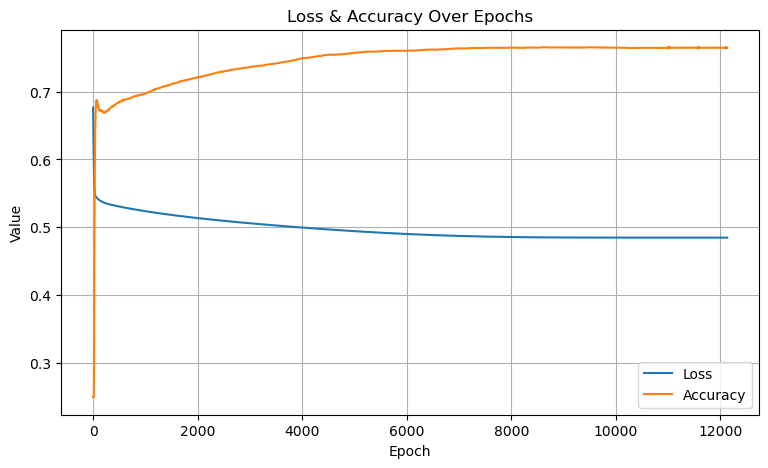

In [269]:
plot_acc_loss(model5)

Accuracy: 0.82

Classification Report:
0.0: {'precision': 0.898, 'recall': 0.883, 'f1-score': 0.891, 'support': 824}
1.0: {'precision': 0.538, 'recall': 0.574, 'f1-score': 0.556, 'support': 195}


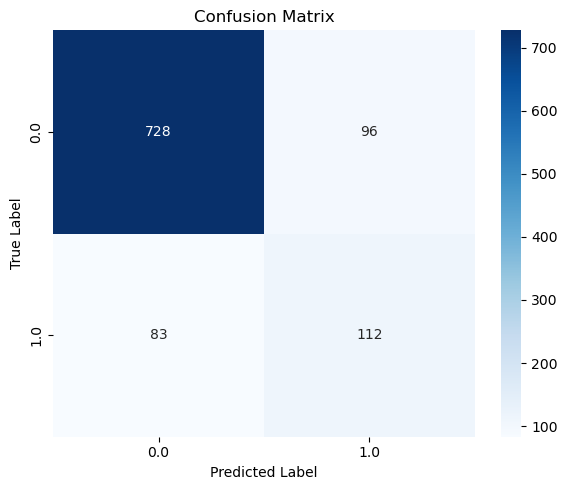

In [270]:
eval_model(model5)

#### 3.3.2.5 Model 6: With Adam, Class Weighting, and Threshold tuning

In [271]:
%%time
model6 = LogisticRegressionAdam(threshold=0.65, print_every=1000, weight_class=True)
model6.fit(X_train, y_train)

Epoch 1: Loss=0.7175, Acc=0.7507
Epoch 1000: Loss=0.6346, Acc=0.7552
Epoch 2000: Loss=0.6219, Acc=0.7630
Epoch 3000: Loss=0.6120, Acc=0.7684
Epoch 4000: Loss=0.6047, Acc=0.7736
Epoch 5000: Loss=0.5998, Acc=0.7773
Epoch 6000: Loss=0.5967, Acc=0.7791
Epoch 7000: Loss=0.5951, Acc=0.7795
Epoch 8000: Loss=0.5945, Acc=0.7801
Epoch 9000: Loss=0.5944, Acc=0.7805
Epoch 10000: Loss=0.5944, Acc=0.7804
Early stopping at epoch 10773
CPU times: user 41.6 s, sys: 2min 35s, total: 3min 16s
Wall time: 29 s


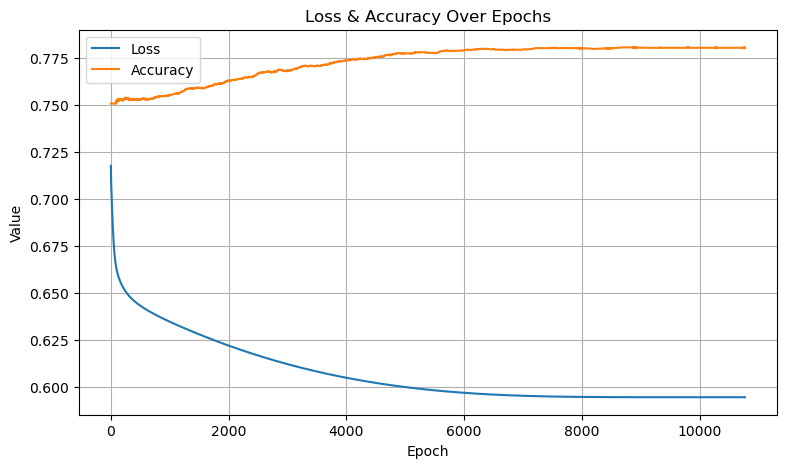

In [272]:
plot_acc_loss(model6)

Accuracy: 0.85

Classification Report:
0.0: {'precision': 0.896, 'recall': 0.919, 'f1-score': 0.907, 'support': 824}
1.0: {'precision': 0.615, 'recall': 0.549, 'f1-score': 0.58, 'support': 195}


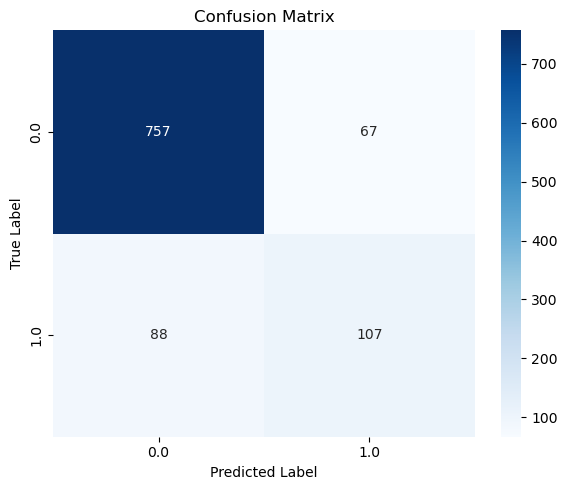

In [273]:
eval_model(model6)

**NOTE:** Evaluate in [README](../README.md) file!